Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1d']
period = '1 month ago UTC'
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset, plot=False):
        self.value = self.calculate(dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print("\n")
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_renko(self, dataset, brick_size=1):
        renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
        renko_.index.name = 'date'
        renko_ = Renko(renko_.reset_index())
        renko_.brick_size = brick_size
        renko_ = renko_.get_ohlc_data().set_index('date')
        renko_.index.name = 'time'
        return renko_.uptrend

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        threshold=1.75, 
                                        method='exponential'):

        volume = dataset[['volume']]
        volume_average = self._calculate_moving_average_(volume, window=average_1, method=method)
        relative_volume = volume / average_1
        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, window=average_2, method=method)
        relative_volume_level = smoothed_relative_volume.iloc[-1] / smoothed_relative_volume.iloc[-2]
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self, dataset, plot):
        self.indicators = Cryptocurrency_indicators_base()
        self.setup(self)
        self.update(self, dataset, plot=plot)

    def setup(self, cls):
        for cls in [cls.indicators, cls]:
            indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for indicator, calculator in zip(indicators, calculators):
                setattr(cls, 
                        indicator[10:], 
                        Cryptocurrency_indicator(name=indicator[10:], 
                                                 calculate=calculator, 
                                                 OHLC=False))

    def update(self, cls, dataset, plot=False):
        for cls in [cls.indicators, cls]:
            indicators = [indicator for indicator in dir(cls)]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for calculator in calculators:
                if isinstance(calculator, Cryptocurrency_indicator):
                    calculator.update(dataset, plot=plot)

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, period=period, download=True, initial_plot=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = period
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators(self.dataset, plot=initial_plot)

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if self.info.pair_buy_balance > self.info.base_asset_balance:
            self.position = 'sell'
        elif self.info.base_asset_balance > self.info.pair_buy_balance:
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info['tick_size'] < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        client.create_order(symbol=self.pair_symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 period=period, 
                 raw_price=True, 
                 download=True, 
                 initial_plot=True):

        self.period = period
        self.raw_price = raw_price
        self.download = download

        self.info = self.get_pair_info(client, pair)
        super().__init__(self)
        self.interval = self.get_datasets(client, intervals, initial_plot=initial_plot)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals, initial_plot=True):
        dataset = dict()

        if self.raw_price:
            dataset['price'] = Cryptocurrency_pair_at_interval(client=client, 
                                                               info=self.info, 
                                                               interval='price', 
                                                               period=self.period, 
                                                               download=self.download, 
                                                               initial_plot=initial_plot)

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                period=self.period, 
                                                                download=self.download, 
                                                                initial_plot=initial_plot)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 period=period, 
                 raw_price=True, 
                 initial_plot=True):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    period, 
                                    raw_price, 
                                    traded_pair_symbols, 
                                    initial_plot=initial_plot)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  period, 
                  raw_price, 
                  traded_pair_symbols, 
                  initial_plot=True):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              period=period, 
                                              raw_price=raw_price, 
                                              download=True, 
                                              initial_plot=initial_plot)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)

In [5]:
client = Client(api_key, api_secret)



time
2020-05-14 16:00:00    612.835909
2020-05-15 16:00:00    612.835909
2020-05-16 16:00:00    612.835909
2020-05-17 16:00:00    612.835909
2020-05-18 16:00:00    612.835909
2020-05-19 16:00:00    612.835909
2020-05-20 16:00:00    612.835909
2020-05-21 16:00:00    612.835909
2020-05-22 16:00:00    612.835909
2020-05-23 16:00:00    612.835909
2020-05-24 16:00:00    612.835909
2020-05-25 16:00:00    612.835909
2020-05-26 16:00:00    612.835909
2020-05-27 16:00:00    612.835909
2020-05-28 16:00:00    605.881201
2020-05-29 16:00:00    588.869687
2020-05-30 16:00:00    576.005424
2020-05-31 16:00:00    593.387893
2020-06-01 16:00:00    619.455187
2020-06-02 16:00:00    643.993388
2020-06-03 16:00:00    628.268860
2020-06-04 16:00:00    614.223227
2020-06-05 16:00:00    589.903711
2020-06-06 16:00:00    563.192017
2020-06-07 16:00:00    553.645445
2020-06-08 16:00:00    526.027913
2020-06-09 16:00:00    510.954490
2020-06-10 16:00:00    525.337741
2020-06-11 16:00:00    548.599331
2020-06

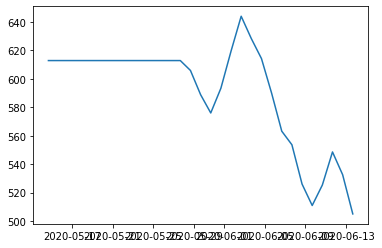





                             K          D           J
time                                                 
2020-05-14 16:00:00  41.307994  47.102665   29.718652
2020-05-15 16:00:00  38.620863  44.275397   27.311793
2020-05-16 16:00:00  49.687621  46.079472   56.903920
2020-05-17 16:00:00  57.455497  49.871480   72.623531
2020-05-18 16:00:00  64.367415  54.703459   83.695328
2020-05-19 16:00:00  57.971193  55.792703   62.328173
2020-05-20 16:00:00  46.096801  52.560736   33.168932
2020-05-21 16:00:00  41.157045  48.759506   25.952124
2020-05-22 16:00:00  38.132597  45.217203   23.963385
2020-05-23 16:00:00  25.964131  38.799512    0.293369
2020-05-24 16:00:00  23.878531  33.825852    3.983890
2020-05-25 16:00:00  20.979401  29.543702    3.850799
2020-05-26 16:00:00  28.902023  29.329809   28.046452
2020-05-27 16:00:00  45.204966  34.621528   66.371843
2020-05-28 16:00:00  56.740562  41.994539   86.232607
2020-05-29 16:00:00  69.875987  51.288355  107.051250
2020-05-30 16:00:00  71.

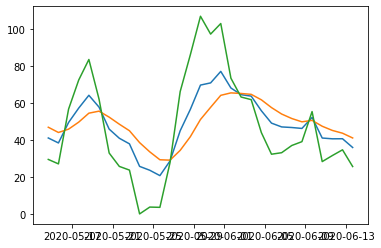





                          MACD  signal_line  histogram
time                                                  
2020-05-14 16:00:00   1.454968     1.454968   0.000000
2020-05-15 16:00:00   1.454968     1.454968   0.000000
2020-05-16 16:00:00  11.118758     5.415538   5.703220
2020-05-17 16:00:00  17.187224     9.403236   7.783988
2020-05-18 16:00:00  21.778264    13.084527   8.693736
2020-05-19 16:00:00  12.835671    13.017073  -0.181402
2020-05-20 16:00:00 -13.179070     6.387528 -19.566599
2020-05-21 16:00:00 -25.590665    -1.297433 -24.293232
2020-05-22 16:00:00 -33.342123    -8.699915 -24.642208
2020-05-23 16:00:00 -61.988711   -20.639699 -41.349012
2020-05-24 16:00:00 -72.229714   -31.927300 -40.302415
2020-05-25 16:00:00 -82.005499   -42.681997 -39.323502
2020-05-26 16:00:00 -67.668657   -47.970042 -19.698615
2020-05-27 16:00:00 -34.509201   -45.154024  10.644823
2020-05-28 16:00:00 -17.892904   -39.502971  21.610067
2020-05-29 16:00:00  11.355167   -29.036746  40.391913
2020-0

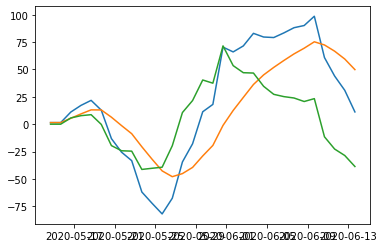





time
2020-05-14 16:00:00    100.000000
2020-05-15 16:00:00    100.000000
2020-05-16 16:00:00    100.000000
2020-05-17 16:00:00    100.000000
2020-05-18 16:00:00    100.000000
2020-05-19 16:00:00     54.640321
2020-05-20 16:00:00     28.730163
2020-05-21 16:00:00     37.004836
2020-05-22 16:00:00     37.749409
2020-05-23 16:00:00     22.427616
2020-05-24 16:00:00     34.999415
2020-05-25 16:00:00     33.011340
2020-05-26 16:00:00     52.309690
2020-05-27 16:00:00     64.065783
2020-05-28 16:00:00     57.746920
2020-05-29 16:00:00     65.086948
2020-05-30 16:00:00     55.177841
2020-05-31 16:00:00     70.968454
2020-06-01 16:00:00     52.898430
2020-06-02 16:00:00     55.911773
2020-06-03 16:00:00     58.416677
2020-06-04 16:00:00     53.667424
2020-06-05 16:00:00     54.826585
2020-06-06 16:00:00     57.033379
2020-06-07 16:00:00     58.051110
2020-06-08 16:00:00     57.621842
2020-06-09 16:00:00     61.486912
2020-06-10 16:00:00     39.445740
2020-06-11 16:00:00     46.629917
2020-

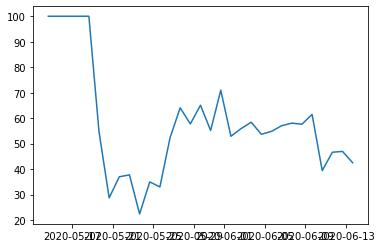





                          ADX     PosDI     NegDI
time                                             
2020-06-09 16:00:00  0.349960  0.135984  0.216664
2020-06-10 16:00:00  0.331665  0.114300  0.182114
2020-06-11 16:00:00  0.316401  0.094626  0.150767
2020-06-12 16:00:00  0.315947  0.084292  0.161207


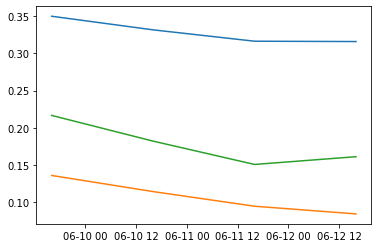





                           BB_up      BB_down    BB_width
time                                                     
2020-06-02 16:00:00  9400.818000  9400.818000    0.000000
2020-06-03 16:00:00  9429.734276  9419.165724   10.568552
2020-06-04 16:00:00  9445.769454  9427.119546   18.649907
2020-06-05 16:00:00  9447.466301  9424.048699   23.417602
2020-06-06 16:00:00  9449.930534  9422.890466   27.040068
2020-06-07 16:00:00  9451.659520  9421.809480   29.850040
2020-06-08 16:00:00  9467.103171  9432.465829   34.637343
2020-06-09 16:00:00  9515.128543  9466.075457   49.053086
2020-06-10 16:00:00  9526.171593  9466.072407   60.099186
2020-06-11 16:00:00  9546.100313  9474.741687   71.358625
2020-06-12 16:00:00  9592.370211  9503.771789   88.598423
2020-06-13 16:00:00  9623.512235  9517.398765  106.113469


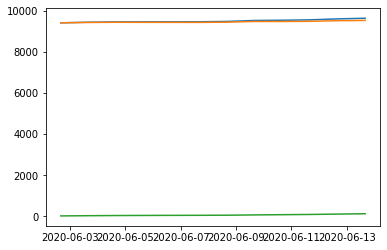





time
2020-05-14 16:00:00         NaN
2020-05-15 16:00:00         NaN
2020-05-16 16:00:00         NaN
2020-05-17 16:00:00         NaN
2020-05-18 16:00:00         NaN
2020-05-19 16:00:00         NaN
2020-05-20 16:00:00         NaN
2020-05-21 16:00:00         NaN
2020-05-22 16:00:00         NaN
2020-05-23 16:00:00         NaN
2020-05-24 16:00:00         NaN
2020-05-25 16:00:00         NaN
2020-05-26 16:00:00         NaN
2020-05-27 16:00:00         NaN
2020-05-28 16:00:00         NaN
2020-05-29 16:00:00         NaN
2020-05-30 16:00:00         NaN
2020-05-31 16:00:00         NaN
2020-06-01 16:00:00         NaN
2020-06-02 16:00:00    0.570265
2020-06-03 16:00:00    0.922981
2020-06-04 16:00:00    0.799156
2020-06-05 16:00:00    0.671269
2020-06-06 16:00:00    0.678043
2020-06-07 16:00:00    0.967775
2020-06-08 16:00:00    0.927010
2020-06-09 16:00:00    1.156748
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.719193

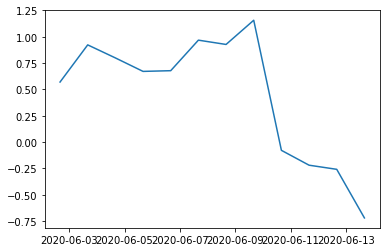





                            open          high          low        close  \
time                                                                       
2020-05-14 16:00:00  9791.970000   9845.620000  9150.000000  9316.420000   
2020-05-15 16:00:00  9434.962500   9652.405000  9202.500000  9365.057500   
2020-05-16 16:00:00  9397.472308   9815.509231  9285.300000  9583.122308   
2020-05-17 16:00:00  9588.927750   9906.290500  9406.077750  9684.917500   
2020-05-18 16:00:00  9685.995372   9900.211818  9451.546364  9745.575455   
2020-05-19 16:00:00  9745.500082   9861.350632  9367.733819  9589.264066   
2020-05-20 16:00:00  9589.381976   9672.677274  8999.076038  9242.029250   
2020-05-21 16:00:00  9241.414290   9404.851604  8955.365351  9194.002430   
2020-05-22 16:00:00  9193.802344   9340.180582  9031.792333  9184.100307   
2020-05-23 16:00:00  9183.940614   9312.059718  8810.593698  8874.921533   
2020-05-24 16:00:00  8873.405118   9090.458655  8698.677268  8891.873940   
2020-05-

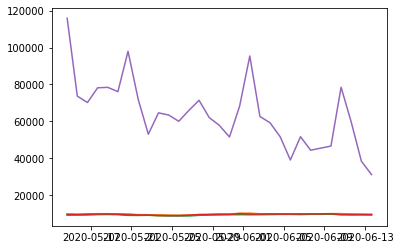





                            open          high          low      close
2020-05-14 16:00:00  9791.970000   9845.620000  9150.000000  9526.0025
2020-05-15 16:00:00  9658.986250   9658.986250  9220.000000  9376.3075
2020-05-16 16:00:00  9517.646875   9888.000000  9322.100000  9567.7375
2020-05-17 16:00:00  9542.692187   9950.000000  9464.230000  9707.3175
2020-05-18 16:00:00  9625.004844   9897.210000  9474.000000  9720.1675
2020-05-19 16:00:00  9672.586172   9842.000000  9326.000000  9613.6400
2020-05-20 16:00:00  9643.113086   9643.113086  8815.000000  9243.3875
2020-05-21 16:00:00  9443.250293   9443.250293  8933.520000  9110.5075
2020-05-22 16:00:00  9276.878896   9307.850000  9070.000000  9181.7500
2020-05-23 16:00:00  9229.314448   9298.000000  8700.000000  8974.3375
2020-05-24 16:00:00  9101.825974   9101.825974  8642.720000  8810.2175
2020-05-25 16:00:00  8956.021737   9017.670000  8700.000000  8864.8000
2020-05-26 16:00:00  8910.410869   9225.000000  8811.730000  9020.4500
20

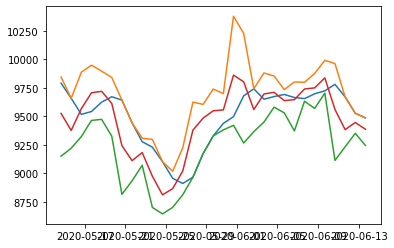





volume    0.0
dtype: float64


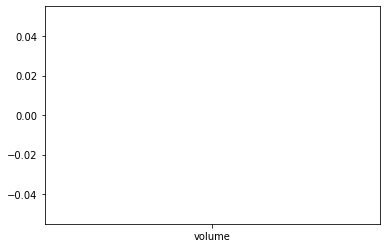





time
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: uptrend, Length: 6419, dtype: float64


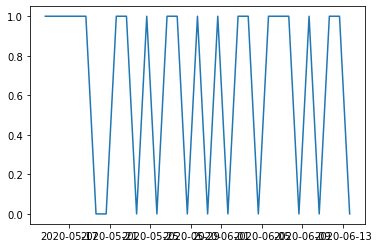





                         open       high       low     close        volume
time                                                                      
2020-05-14 16:00:00  9553.965   9716.810  9185.000  9348.845  87739.194689
2020-05-15 16:00:00  9553.965   9716.810  9185.000  9348.845  87739.194689
2020-05-16 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696092
2020-05-17 16:00:00  9530.960   9919.000  9393.165  9706.985  75327.183953
2020-05-18 16:00:00  9707.520   9923.605  9469.115  9754.730  80273.182018
2020-05-19 16:00:00  9754.530   9869.605  9400.000  9643.480  76731.749272
2020-05-20 16:00:00  9643.280   9710.235  9070.500  9290.040  91926.259529
2020-05-21 16:00:00  9289.470   9424.735  8874.260  9119.325  83935.955996
2020-05-22 16:00:00  9118.755   9289.425  9001.760  9174.575  51234.713995
2020-05-23 16:00:00  9174.505   9302.925  8885.000  8949.745  56953.081708
2020-05-24 16:00:00  8948.575   9138.830  8671.360  8810.345  66606.888699
2020-05-25 16:00:00  

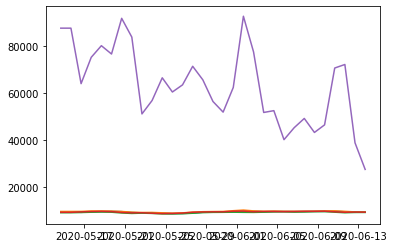





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: histogram, dtype: float64


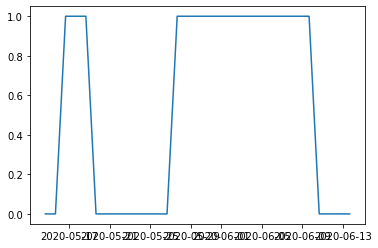





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    0.0
2020-06-07 16:00:00    0.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
dtype: float64


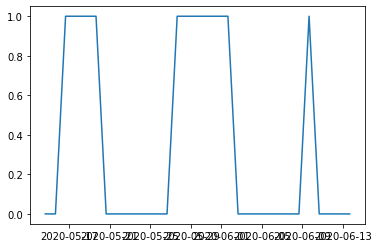





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: close, dtype: float64


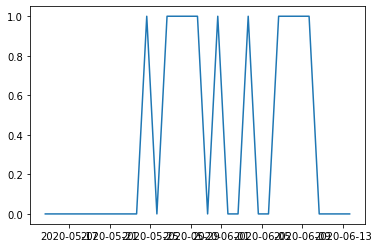





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
dtype: float64


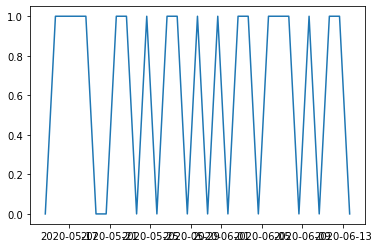





time
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
dtype: float64


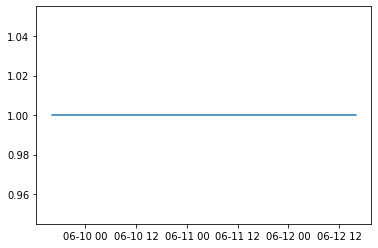





time
2020-06-09 16:00:00    0.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
dtype: float64


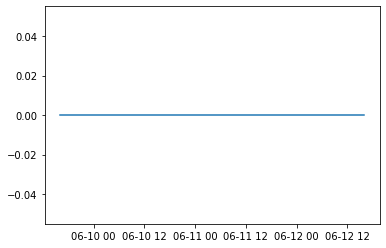





time
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
Name: ADX, dtype: float64


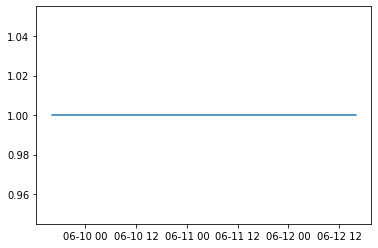





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
dtype: float64


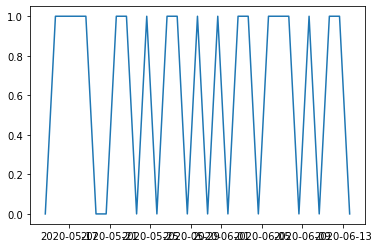





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    0.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
dtype: float64


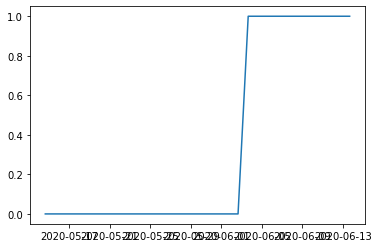





time
2020-05-14 16:00:00    612.835909
2020-05-15 16:00:00    612.835909
2020-05-16 16:00:00    612.835909
2020-05-17 16:00:00    612.835909
2020-05-18 16:00:00    612.835909
2020-05-19 16:00:00    612.835909
2020-05-20 16:00:00    612.835909
2020-05-21 16:00:00    612.835909
2020-05-22 16:00:00    612.835909
2020-05-23 16:00:00    612.835909
2020-05-24 16:00:00    612.835909
2020-05-25 16:00:00    612.835909
2020-05-26 16:00:00    612.835909
2020-05-27 16:00:00    612.835909
2020-05-28 16:00:00    605.881201
2020-05-29 16:00:00    588.869687
2020-05-30 16:00:00    576.005424
2020-05-31 16:00:00    593.387893
2020-06-01 16:00:00    619.455187
2020-06-02 16:00:00    643.993388
2020-06-03 16:00:00    628.268860
2020-06-04 16:00:00    614.223227
2020-06-05 16:00:00    589.903711
2020-06-06 16:00:00    563.192017
2020-06-07 16:00:00    553.645445
2020-06-08 16:00:00    526.027913
2020-06-09 16:00:00    510.954490
2020-06-10 16:00:00    525.337741
2020-06-11 16:00:00    548.599331
2020-

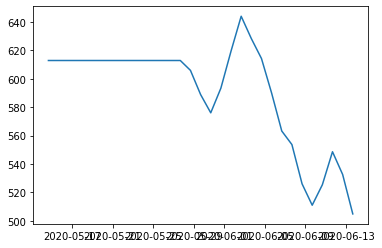





                             K          D           J
time                                                 
2020-05-14 16:00:00  41.307994  47.102665   29.718652
2020-05-15 16:00:00  38.620863  44.275397   27.311793
2020-05-16 16:00:00  49.687621  46.079472   56.903920
2020-05-17 16:00:00  57.455497  49.871480   72.623531
2020-05-18 16:00:00  64.367415  54.703459   83.695328
2020-05-19 16:00:00  57.971193  55.792703   62.328173
2020-05-20 16:00:00  46.096801  52.560736   33.168932
2020-05-21 16:00:00  41.157045  48.759506   25.952124
2020-05-22 16:00:00  38.132597  45.217203   23.963385
2020-05-23 16:00:00  25.964131  38.799512    0.293369
2020-05-24 16:00:00  23.878531  33.825852    3.983890
2020-05-25 16:00:00  20.979401  29.543702    3.850799
2020-05-26 16:00:00  28.902023  29.329809   28.046452
2020-05-27 16:00:00  45.204966  34.621528   66.371843
2020-05-28 16:00:00  56.740562  41.994539   86.232607
2020-05-29 16:00:00  69.875987  51.288355  107.051250
2020-05-30 16:00:00  71.

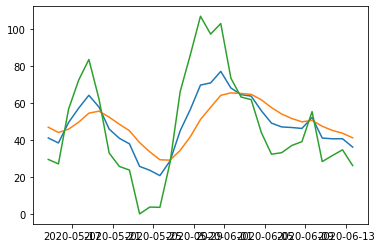





                          MACD  signal_line  histogram
time                                                  
2020-05-14 16:00:00   1.454968     1.454968   0.000000
2020-05-15 16:00:00   1.454968     1.454968   0.000000
2020-05-16 16:00:00  11.118758     5.415538   5.703220
2020-05-17 16:00:00  17.187224     9.403236   7.783988
2020-05-18 16:00:00  21.778264    13.084527   8.693736
2020-05-19 16:00:00  12.835671    13.017073  -0.181402
2020-05-20 16:00:00 -13.179070     6.387528 -19.566599
2020-05-21 16:00:00 -25.590665    -1.297433 -24.293232
2020-05-22 16:00:00 -33.342123    -8.699915 -24.642208
2020-05-23 16:00:00 -61.988711   -20.639699 -41.349012
2020-05-24 16:00:00 -72.229714   -31.927300 -40.302415
2020-05-25 16:00:00 -82.005499   -42.681997 -39.323502
2020-05-26 16:00:00 -67.668657   -47.970042 -19.698615
2020-05-27 16:00:00 -34.509201   -45.154024  10.644823
2020-05-28 16:00:00 -17.892904   -39.502971  21.610067
2020-05-29 16:00:00  11.355167   -29.036746  40.391913
2020-0

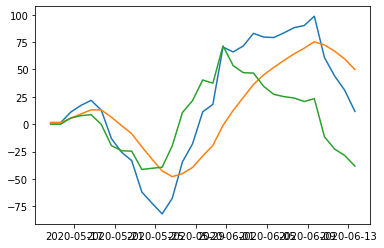





time
2020-05-14 16:00:00    100.000000
2020-05-15 16:00:00    100.000000
2020-05-16 16:00:00    100.000000
2020-05-17 16:00:00    100.000000
2020-05-18 16:00:00    100.000000
2020-05-19 16:00:00     54.640321
2020-05-20 16:00:00     28.730163
2020-05-21 16:00:00     37.004836
2020-05-22 16:00:00     37.749409
2020-05-23 16:00:00     22.427616
2020-05-24 16:00:00     34.999415
2020-05-25 16:00:00     33.011340
2020-05-26 16:00:00     52.309690
2020-05-27 16:00:00     64.065783
2020-05-28 16:00:00     57.746920
2020-05-29 16:00:00     65.086948
2020-05-30 16:00:00     55.177841
2020-05-31 16:00:00     70.968454
2020-06-01 16:00:00     52.898430
2020-06-02 16:00:00     55.911773
2020-06-03 16:00:00     58.416677
2020-06-04 16:00:00     53.667424
2020-06-05 16:00:00     54.826585
2020-06-06 16:00:00     57.033379
2020-06-07 16:00:00     58.051110
2020-06-08 16:00:00     57.621842
2020-06-09 16:00:00     61.486912
2020-06-10 16:00:00     39.445740
2020-06-11 16:00:00     46.629917
2020-

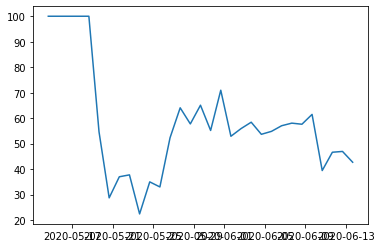





                          ADX     PosDI     NegDI
time                                             
2020-06-09 16:00:00  0.349960  0.135984  0.216664
2020-06-10 16:00:00  0.331665  0.114300  0.182114
2020-06-11 16:00:00  0.316401  0.094626  0.150767
2020-06-12 16:00:00  0.315947  0.084292  0.161207


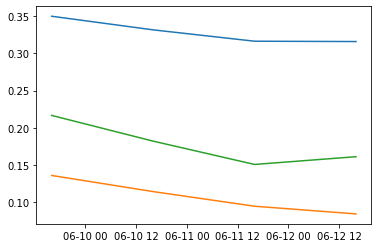





                           BB_up      BB_down    BB_width
time                                                     
2020-06-02 16:00:00  9400.818000  9400.818000    0.000000
2020-06-03 16:00:00  9429.734276  9419.165724   10.568552
2020-06-04 16:00:00  9445.769454  9427.119546   18.649907
2020-06-05 16:00:00  9447.466301  9424.048699   23.417602
2020-06-06 16:00:00  9449.930534  9422.890466   27.040068
2020-06-07 16:00:00  9451.659520  9421.809480   29.850040
2020-06-08 16:00:00  9467.103171  9432.465829   34.637343
2020-06-09 16:00:00  9515.128543  9466.075457   49.053086
2020-06-10 16:00:00  9526.171593  9466.072407   60.099186
2020-06-11 16:00:00  9546.100313  9474.741687   71.358625
2020-06-12 16:00:00  9592.370211  9503.771789   88.598423
2020-06-13 16:00:00  9623.851580  9517.661420  106.190159


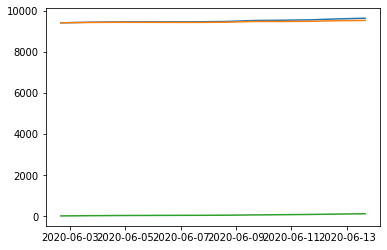





time
2020-05-14 16:00:00         NaN
2020-05-15 16:00:00         NaN
2020-05-16 16:00:00         NaN
2020-05-17 16:00:00         NaN
2020-05-18 16:00:00         NaN
2020-05-19 16:00:00         NaN
2020-05-20 16:00:00         NaN
2020-05-21 16:00:00         NaN
2020-05-22 16:00:00         NaN
2020-05-23 16:00:00         NaN
2020-05-24 16:00:00         NaN
2020-05-25 16:00:00         NaN
2020-05-26 16:00:00         NaN
2020-05-27 16:00:00         NaN
2020-05-28 16:00:00         NaN
2020-05-29 16:00:00         NaN
2020-05-30 16:00:00         NaN
2020-05-31 16:00:00         NaN
2020-06-01 16:00:00         NaN
2020-06-02 16:00:00    0.570265
2020-06-03 16:00:00    0.922981
2020-06-04 16:00:00    0.799156
2020-06-05 16:00:00    0.671269
2020-06-06 16:00:00    0.678043
2020-06-07 16:00:00    0.967775
2020-06-08 16:00:00    0.927010
2020-06-09 16:00:00    1.156748
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.711979

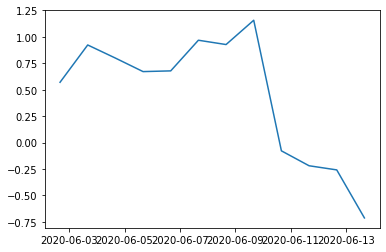





                            open          high          low        close  \
time                                                                       
2020-05-14 16:00:00  9791.970000   9845.620000  9150.000000  9316.420000   
2020-05-15 16:00:00  9434.962500   9652.405000  9202.500000  9365.057500   
2020-05-16 16:00:00  9397.472308   9815.509231  9285.300000  9583.122308   
2020-05-17 16:00:00  9588.927750   9906.290500  9406.077750  9684.917500   
2020-05-18 16:00:00  9685.995372   9900.211818  9451.546364  9745.575455   
2020-05-19 16:00:00  9745.500082   9861.350632  9367.733819  9589.264066   
2020-05-20 16:00:00  9589.381976   9672.677274  8999.076038  9242.029250   
2020-05-21 16:00:00  9241.414290   9404.851604  8955.365351  9194.002430   
2020-05-22 16:00:00  9193.802344   9340.180582  9031.792333  9184.100307   
2020-05-23 16:00:00  9183.940614   9312.059718  8810.593698  8874.921533   
2020-05-24 16:00:00  8873.405118   9090.458655  8698.677268  8891.873940   
2020-05-

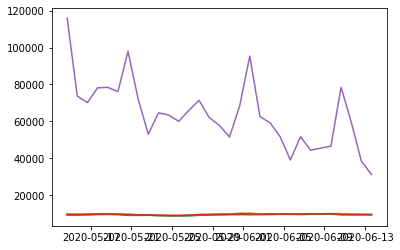





                            open          high          low      close
2020-05-14 16:00:00  9791.970000   9845.620000  9150.000000  9526.0025
2020-05-15 16:00:00  9658.986250   9658.986250  9220.000000  9376.3075
2020-05-16 16:00:00  9517.646875   9888.000000  9322.100000  9567.7375
2020-05-17 16:00:00  9542.692187   9950.000000  9464.230000  9707.3175
2020-05-18 16:00:00  9625.004844   9897.210000  9474.000000  9720.1675
2020-05-19 16:00:00  9672.586172   9842.000000  9326.000000  9613.6400
2020-05-20 16:00:00  9643.113086   9643.113086  8815.000000  9243.3875
2020-05-21 16:00:00  9443.250293   9443.250293  8933.520000  9110.5075
2020-05-22 16:00:00  9276.878896   9307.850000  9070.000000  9181.7500
2020-05-23 16:00:00  9229.314448   9298.000000  8700.000000  8974.3375
2020-05-24 16:00:00  9101.825974   9101.825974  8642.720000  8810.2175
2020-05-25 16:00:00  8956.021737   9017.670000  8700.000000  8864.8000
2020-05-26 16:00:00  8910.410869   9225.000000  8811.730000  9020.4500
20

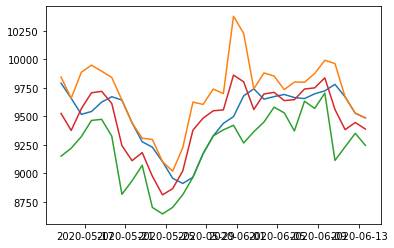





volume    0.0
dtype: float64


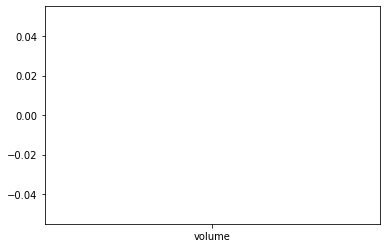





time
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-15 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: uptrend, Length: 6413, dtype: float64


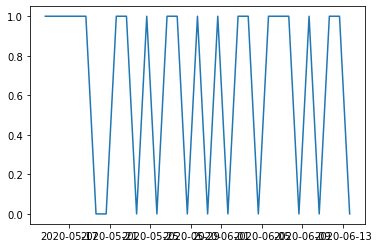





                         open       high       low     close        volume
time                                                                      
2020-05-14 16:00:00  9553.965   9716.810  9185.000  9348.845  87739.194689
2020-05-15 16:00:00  9553.965   9716.810  9185.000  9348.845  87739.194689
2020-05-16 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696092
2020-05-17 16:00:00  9530.960   9919.000  9393.165  9706.985  75327.183953
2020-05-18 16:00:00  9707.520   9923.605  9469.115  9754.730  80273.182018
2020-05-19 16:00:00  9754.530   9869.605  9400.000  9643.480  76731.749272
2020-05-20 16:00:00  9643.280   9710.235  9070.500  9290.040  91926.259529
2020-05-21 16:00:00  9289.470   9424.735  8874.260  9119.325  83935.955996
2020-05-22 16:00:00  9118.755   9289.425  9001.760  9174.575  51234.713995
2020-05-23 16:00:00  9174.505   9302.925  8885.000  8949.745  56953.081708
2020-05-24 16:00:00  8948.575   9138.830  8671.360  8810.345  66606.888699
2020-05-25 16:00:00  

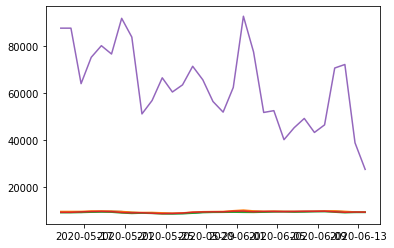





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: histogram, dtype: float64


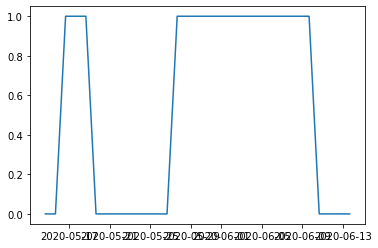





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    0.0
2020-06-07 16:00:00    0.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
dtype: float64


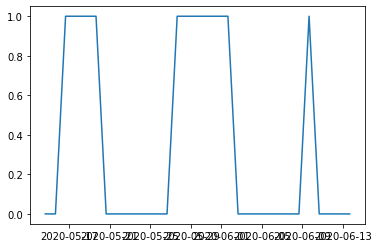





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
Name: close, dtype: float64


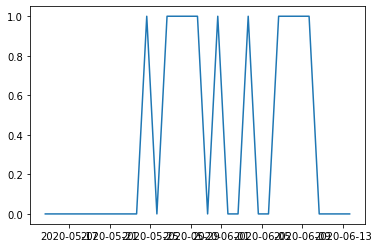





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
dtype: float64


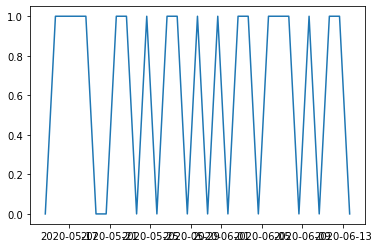





time
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
dtype: float64


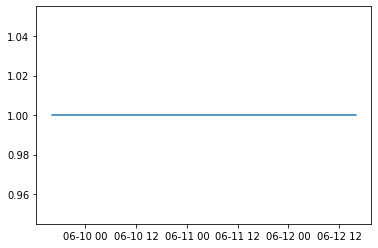





time
2020-06-09 16:00:00    0.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
dtype: float64


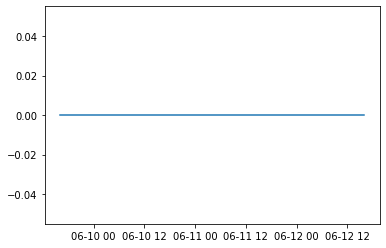





time
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
Name: ADX, dtype: float64


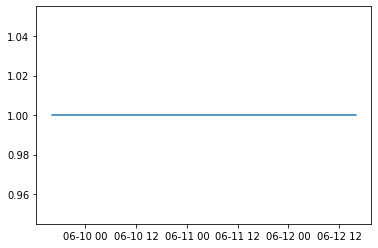





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
dtype: float64


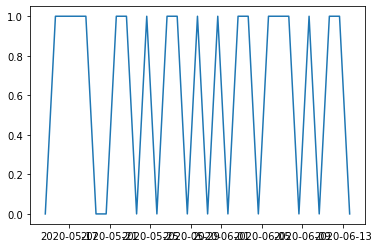





time
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    0.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
dtype: float64


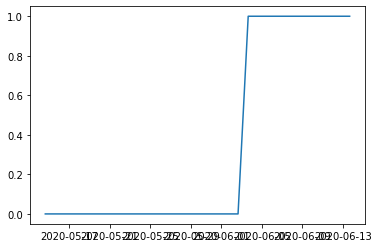

In [6]:
crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                period=period, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [ ]:
'''
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    dataset = crypto_bot.pairs[symbol].interval[interval].dataset
    precision = crypto_bot.pairs[symbol].info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        crypto_bot.pairs[symbol].interval[interval].dataset = dataset
        crypto_bot.pairs[symbol].interval[interval].calculate_indicators()

        if symbol == crypto_bot.traded_pair_symbol:
            if crypto_bot.pairs[symbol].state == 'exit':

                if crypto_bot.pairs[symbol].position == 'sell' and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.volatility_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.MACD_trigger.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.real_trigger.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.momentum_trigger.iloc[-1]:

                    crypto_bot.pairs[symbol].trade()

                elif crypto_bot.pairs[symbol].position == 'buy' and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.volatility_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.MACD_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.real_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.momentum_trigger.iloc[-1]:

                    crypto_bot.pairs[symbol].trade()

            elif crypto_bot.pairs[symbol].state == 'entry':

                if crypto_bot.pairs[symbol].position == 'sell' and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.volatility_trigger.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.MACD_trigger.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.real_trigger.iloc[-1] and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.momentum_trigger.iloc[-1]:

                    crypto_bot.pairs[symbol].trade()

                elif crypto_bot.pairs[symbol].position == 'buy' and \
                        crypto_bot.pairs[symbol].interval[interval].indicators.volatility_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.MACD_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.real_trigger.iloc[-1] and \
                        not crypto_bot.pairs[symbol].interval[interval].indicators.momentum_trigger.iloc[-1]:

                    crypto_bot.pairs[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()
'''

In [ ]:
# --- Development separation --- #

In [ ]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

datasets = dict()
for symbol in symbols.keys():
    datasets.update({symbol: {'price': None, 
                              '15s': pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume']), 
                              '1m': pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])}})

def process_message(msg):
    global datasets, traded_symbol, intervals
    four_hours = 14400
    millisecond = 1000

    msg = msg['data']
    symbol = msg['s']
    dataset = datasets[symbol]
    price = dataset['price']
    quote_asset_precision = symbols[symbol].quote_asset_precision

    last_data = \
        pd.DataFrame([["{:0.0{}f}".format(float(msg['a']), quote_asset_precision).rstrip('0').rstrip('.'), 
                       "{:0.0{}f}".format(float(msg['p']), quote_asset_precision).rstrip('0').rstrip('.'), 
                       "{:0.0{}f}".format(float(msg['q']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                     index=[datetime.datetime.fromtimestamp(int(msg['E'] / millisecond) - four_hours)], 
                     columns=['id', 'price', 'quantity'])

    last_data.index.name = 'time'

    if price is None:
        dataset.update({'price': last_data})
    elif price['id'].iloc[-1] > last_data['id'].iloc[-1]:
        price = price.append(last_data).iloc[-1000:]

    for interval in intervals:
        dataset[interval] = make_OHLC_dataset(price, interval=interval)

    dataset['price'] = price
    datasets[symbol] = dataset
    datasets[symbol].calculate_indicators()

    if symbol == traded_symbol:
        if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@trade' for symbol in symbols.keys()], 
                                     process_message)
bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()